In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# --- 1️⃣ Load dataset ---
data_path = r"D:\CSE(DataScience)\Customer_Churn_Prediction\Datasets\Telco-Customer-Churn-dataset.csv"
df = pd.read_csv(data_path)

# Quick cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Map target
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# --- 2️⃣ Features ---
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('Churn')
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# --- 3️⃣ Preprocessing pipeline ---
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# --- 4️⃣ Train/Test split ---
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 5️⃣ Fit model ---
pipeline.fit(X_train, y_train)

# --- 6️⃣ Make predictions ---
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:,1]

# --- 7️⃣ Save prediction output ---
output_dir = os.path.abspath(os.path.join('..','outputs'))
os.makedirs(output_dir, exist_ok=True)

prediction_output = pd.DataFrame({
    'CustomerIndex': X_test.index,
    'ActualChurn': y_test,
    'PredictedChurn': y_pred,
    'ChurnProbability': y_prob
})

output_path = os.path.join(output_dir, 'prediction_output.csv')
prediction_output.to_csv(output_path, index=False)

print("Prediction output saved at:", output_path)

Prediction output saved at: D:\CSE(DataScience)\Customer_Churn_Prediction\outputs\prediction_output.csv


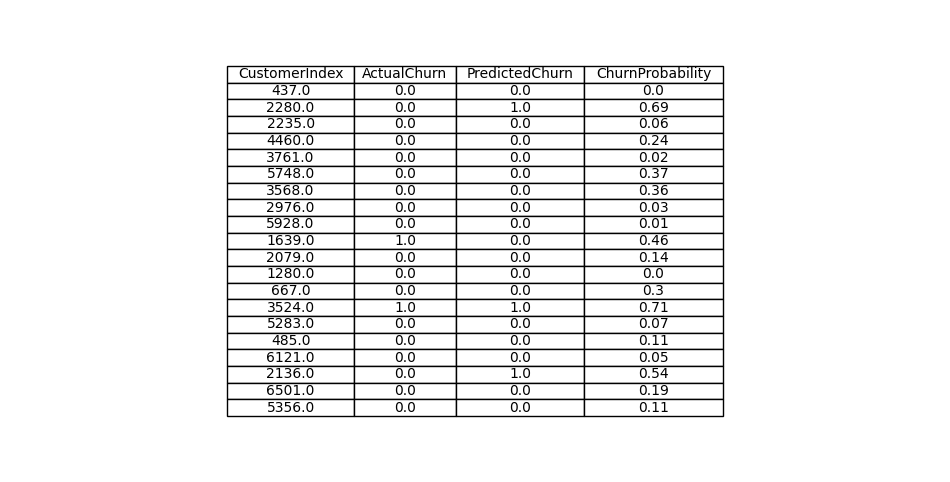

In [6]:
import matplotlib.pyplot as plt

# Set figure size
fig, ax = plt.subplots(figsize=(12,6))
ax.axis('off')

# Create table plot
table = ax.table(
    cellText=prediction_output.head(20).values,
    colLabels=prediction_output.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0,1,2,3])

# Save as PNG
plt.savefig("../screenshots/prediction_output.png", bbox_inches='tight')
plt.show()